# Initialization

In [1]:
%matplotlib inline

In [55]:
import os

import numpy as np
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr

import ipywidgets as widgets
import xgcm

from numpy import pi as π

import sys
sys.path.append('../analysis/')
# m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox

sys.path.insert(0, '../pittwolfe')
import pittwolfe as pw
from pittwolfe.util import sind, cosd

latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)

## Specify the experiment

In [3]:
####
# flat bottom 2-layer base 0.5º experiment
# expdir = '../../flat/base'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 2-layer 0.25º experiment
# expdir = '../../flat/0.25'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 900

####
# flat bottom 2-layer 0.5º experiment with GM & K = 500
# expdir = '../../flat/gm_0500'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 3-layer base 0.5º experiment
# expdir = '../../flat/3layer/0.5'
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# recirc_lon0 = 1.25
# Ah = 1e4

####
# flat bottom 3-layer 0.25º experiment
# expdir = '../../flat/3layer/0.25'
# recirc_lon = [0, 8]
# recirc_lat = [31, 38]
# Ah = 900

####
# flat bottom 3-layer 0.125º experiment
# expdir = '../../flat/3layer/0.125'
# recirc_lon = [0, 10]
# recirc_lat = [28, 38]
# Ah = 100

####
# flat bottom 3-layer 0.125º experiment without Smagorinski viscosity
# expdir = '../../flat/3layer/0.125/nosmag'
# recirc_lon = [0, 10]
# recirc_lat = [26, 36]
# Ah = 100

####
# sloping sidewalls, 0.5º 
# expdir = '../../slope/base'
# recirc_lon0 = 1.25
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# Ah = 1e4

####
# sloping sidewalls, 0.25º 
# expdir = '../../slope/0.25'
# recirc_lon0 = 4.5
# recirc_lon = [0, 10]
# recirc_lat = [31, 38]
# Ah = 900

####
# sloping sidewalls, 3-layer, 0.5º 
# expdir = '../../slope/3layer/0.5'
# recirc_lon0 = 1.25
# recirc_lon = [0, 8]
# recirc_lat = [32, 39]
# Ah = 1e4

####
# sloping sidewalls, 3-layer, 0.125º 
expdir = '../../slope/3layer/0.125'
recirc_lon = [2, 12]
recirc_lat = [28, 38]
Ah = 100



# Function definitions

In [4]:
def savefig(fig, name, pdf=True, png=True):
    if pdf:
        fig.savefig(os.path.join(expdir, name + '.pdf'), bbox_inches='tight')
    if png:
        fig.savefig(os.path.join(expdir, name + '.png'), bbox_inches='tight', dpi=150)

<GeoAxesSubplot:>

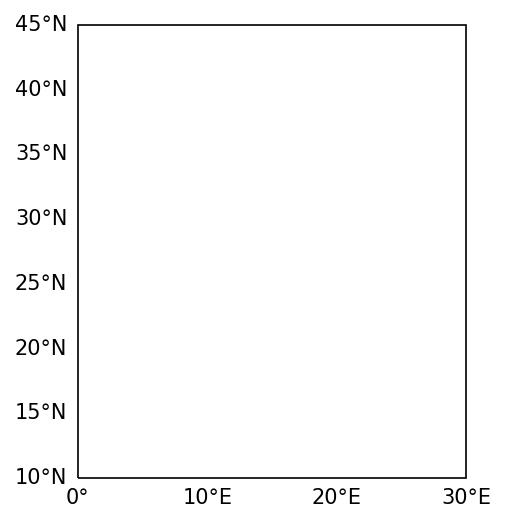

In [5]:
def setup_cartopy_plot(ax=None, bottom_labels=True, left_labels=True):
    data_projection = ccrs.PlateCarree()
    map_projection = ccrs.PlateCarree()
#     map_projection = ccrs.AlbersEqualArea(central_longitude=15, 
#                                           central_latitude=25,
#                                           standard_parallels=(20.0, 50.0))

    if ax is None:
        ax = plt.axes(projection=map_projection)

    ax.set_extent([-0.001, 30.001, 9.999, 45.0001], crs=ccrs.PlateCarree())
    gl = ax.gridlines(xlocs=np.arange(0, 31, 10), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = bottom_labels
    gl.left_labels = left_labels
    gl.xlines = False
    gl.ylines = False

    vertices = [
        [ 0, 10],
        [30, 10],
        [30, 45],
        [ 0, 45],
        [ 0, 10]
    ]

    path = mpath.Path(vertices).interpolated(20)

#     ax.background_patch.set_facecolor('.5')
#     xlocs = np.arange(-90, 240, 30)
#     ylocs = np.arange(-75, 90, 15)
#     ax.gridlines(xlocs=xlocs, ylocs=ylocs, linewidth=.5)
#     ax.set_boundary(path, transform=data_projection)
    
    return ax

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
setup_cartopy_plot(ax)

<AxesSubplot:>

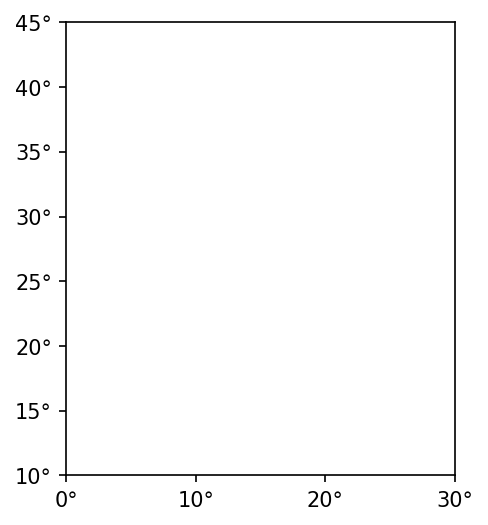

In [6]:
def setup_plan_plot(ax=None):
    if ax is None:
        ax = plt.axes()

    ax.set_xlim(0, 30)
    ax.set_ylim(10, 45)
    
    yticks = np.arange(10, 46, 5)
    latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
    ax.set_yticks(yticks)
    ax.set_yticklabels(latFormatter.format(yticks))
    
    xticks = np.arange(0, 31, 10)
    lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(lonFormatter.format(xticks))
    
    ax.set_aspect(1)
    
    return ax

fig, ax = plt.subplots()
setup_plan_plot(ax)

In [7]:
def integer_ticks(vmax, symmetric=True, spacing=None, nticks=None):
    '''
    Returns an array with ticks spaced by an integer and centered around zero.
    
    nticks is the number of non-negative ticks
    '''
    
    if spacing is not None and nticks is not None:
        raise RuntimeError("Can't specify both spacing and nticks")
        
    if spacing is not None:
        if symmetric:
            vmin = -np.floor(vmax/spacing)*spacing
        else:
            vmin = 0
            
        return np.arange(vmin, vmax*(1 + .01), spacing)
    
    if nticks is None:
        nticks = 4
        
    spacing = np.ceil(vmax/nticks)
    if symmetric:
        vmin = -np.floor(vmax/spacing)*spacing
    else:
        vmin = 0
    return np.arange(vmin, vmax*(1 + .01), spacing)
    

In [8]:
def round_up(x, multiple=1):
    '''
    Round up to the next multiple of 'multiple'
    '''
    x = float(x)
    
    if x > 0:
        return np.ceil(x/multiple)*multiple
    elif x < 0:
        return np.floor(x/multiple)*multiple
    else:
        return 0.0
    
def round_down(x, multiple=1):
    '''
    Round down to the next multiple of 'multiple'
    '''
    x = float(x)
    
    if x > 0:
        return np.floor(x/multiple)*multiple
    elif x < 0:
        return np.ceil(x/multiple)*multiple
    else:
        return 0.0

# Load datasets

## Constants

In [9]:
ρ0 = 1035 # Boussinesq reference density
g = 9.8
Ω = 7.29e-5
a = 6370e3
Δλ = 0.5 # zonal grid spacing
dpy = 360 # days per year

tavg = 50*dpy # number of days to average

## Grid

MOM calls coordinates different things in different outputs. This enforces as uniform standard.

In [10]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

Vertical coordinates are annoyingly not in `ocean_geometry.nc`. We load them from the initial conditions and add them to the grid.

In [11]:
grid = xr.open_dataset(os.path.join(expdir, 'OUTPUT/ocean_geometry.nc')).rename(coord_map_h)
ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v})

max_depth = float(grid.D.max())

grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

grid['fh'] = 2*Ω*sind(grid.yh)
grid['fq'] = 2*Ω*sind(grid.yq)

grid['βh'] = 2*Ω*cosd(grid.yh)/a
grid['βq'] = 2*Ω*cosd(grid.yq)/a

grid['maskH'] = grid.wet
grid['maskU'] = (['yh', 'xq'], np.ones((Ny, Nx+1)))
grid['maskU'][:,[0, -1]] = 0
grid['maskV'] = (['yq', 'xh'], np.ones((Ny+1, Nx)))
grid['maskV'][[0, -1],:] = 0

grid['maskZ'] = (['yq', 'xq'], np.ones((Ny+1, Nx+1)))
grid['maskZ'][[0, -1],:] = 0
grid['maskZ'][:,[0, -1]] = 0

# width of the basin in meters
grid['Lx_q'] = a*np.deg2rad(grid.geolonb.isel(xq=-1,yq=0))*cosd(grid.yq)
grid['Lx_h'] = a*np.deg2rad(grid.geolonb.isel(xq=-1,yq=0))*cosd(grid.yh)

grid

<xarray.Dataset>
Dimensions:  (yh: 321, xh: 240, yq: 322, xq: 241, zi: 4, zl: 3)
Coordinates:
  * yh       (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq       (yq) float64 10.0 10.12 10.25 10.37 ... 44.5 44.59 44.68 44.77
  * xq       (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.62 29.75 29.87 30.0
    Time     timedelta64[ns] -69504 days +00:25:26.290448384
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.039e+03
  * zl       (zl) float64 1.035e+03 1.037e+03 1.038e+03
Data variables: (12/30)
    geolatb  (yq, xq) float64 ...
    geolonb  (yq, xq) float64 ...
    geolat   (yh, xh) float64 ...
    geolon   (yh, xh) float64 ...
    D        (yh, xh) float64 100.5 101.2 102.8 106.0 ... 101.6 100.9 100.5
    f        (yq, xq) float64 ...
    ...       ...
    maskH    (yh, xh) float64 ...
    maskU    (yh, xq) float64 0.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 0.0
    maskV    (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    maskZ    (yq, xq) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Lx_q     (yq) float64 3.285e+06 3.283e+06 3.282e+06 ... 2.371e+06 2.368e+06
    Lx_h     (yh) float64 3.284e+06 3.283e+06 3.281e+06 ... 2.373e+06 2.37e+06
Attributes:
    filename:  ./ocean_geometry.nc

In [12]:
grid_op = xgcm.Grid(grid, periodic=False, boundary='fill', fill_value=0, coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'inner': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (not periodic, boundary='fill'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='fill'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='fill'):
  * inner    zl
  * outer    zi

## Prognostic variables

In [13]:
prog = xr.open_mfdataset(os.path.join(expdir, 'OUTPUT/ave_prog*.nc'), decode_times=False)

prog

<xarray.Dataset>
Dimensions:     (xq: 241, yh: 321, zl: 3, time: 500, nv: 2, xh: 240, yq: 322, zi: 4)
Coordinates:
  * xq          (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.62 29.75 29.87 30.0
  * yh          (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * zl          (zl) float64 1.035e+03 1.037e+03 1.038e+03
  * time        (time) float64 180.0 540.0 900.0 ... 1.795e+05 1.798e+05
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq          (yq) float64 10.0 10.12 10.25 10.37 ... 44.5 44.59 44.68 44.77
  * zi          (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.039e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(100, 3, 321, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(100, 3, 322, 240), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(100, 3, 321, 240), meta=np.ndarray>
    e           (time, zi, yh, xh) float32 dask.array<chunksize=(100, 4, 321, 240), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

## Continuity

In [14]:
cont = xr.open_mfdataset(os.path.join(expdir, 'OUTPUT/cont*.nc'), decode_times=False)
cont

<xarray.Dataset>
Dimensions:     (xq: 241, yh: 321, zl: 3, time: 500, nv: 2, xh: 240, yq: 322)
Coordinates:
  * xq          (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.62 29.75 29.87 30.0
  * yh          (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * zl          (zl) float64 1.035e+03 1.037e+03 1.038e+03
  * time        (time) float64 180.0 540.0 900.0 ... 1.795e+05 1.798e+05
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq          (yq) float64 10.0 10.12 10.25 10.37 ... 44.5 44.59 44.68 44.77
Data variables:
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(100, 3, 321, 241), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(100, 3, 322, 240), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

# Streamfunctions

In [15]:
psi = grid_op.cumsum(cont.vh, axis='X', to='outer', boundary='fill')/1e6
psiB = psi.sum(dim='zl')

In [16]:
float(η0.max())

NameError: name 'η0' is not defined

In [24]:
grid.D

<xarray.DataArray 'D' (yh: 321, xh: 240)>
array([[100.520176, 101.234879, 102.79081 , ..., 102.79081 , 101.234879,
        100.520176],
       [100.520087, 101.234283, 102.788696, ..., 102.788696, 101.234283,
        100.520087],
       [100.519998, 101.23368 , 102.786558, ..., 102.786558, 101.23368 ,
        100.519998],
       ...,
       [100.459841, 100.868271, 101.597649, ..., 101.597649, 100.868271,
        100.459841],
       [100.459613, 100.86703 , 101.594004, ..., 101.594004, 100.86703 ,
        100.459613],
       [100.459385, 100.865792, 101.590367, ..., 101.590367, 100.865792,
        100.459385]])
Coordinates:
  * yh       (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
    Time     timedelta64[ns] -69504 days +00:25:26.290448384
Attributes:
    long_name:  Basin Depth
    units:      meter

# Animate

## Interface height

In [18]:
η0 = 100*prog.e.isel(zi=0)
η1 = prog.e.isel(zi=1).where(prog.e.isel(zi=1) > -grid.D + .1)
η2 = prog.e.isel(zi=2).where(prog.e.isel(zi=2) > -grid.D + .1)

vms = [
    [round_up(η0.min(), 10), round_up(η0.max(), 10)],
    [round_up(η1.min(), 10), round_down(η1.max(), 10)],
    [round_up(η2.min(), 10), round_down(η2.max(), 10)],
]

levels = [np.linspace(vm[0], vm[1], 31) for vm in vms]

In [35]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpyjgkwbjv


In [54]:
for time in range(len(η0.time)):
    with mpl.style.context({'font.size': 8}):
        fig, axs = plt.subplots(ncols=Nl, sharex=True, sharey=True, figsize=(6.5, 3.5))
        fig.set_facecolor('w')

        for n, (fld, ax) in enumerate(zip((η0.isel(time=time), η1.isel(time=time), η2.isel(time=time)), axs)):
            setup_plan_plot(ax)
            ax.set_facecolor('0.7')
            vmin = vms[n][0]
            vmax = vms[n][1]
            cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels[n], vmin=vmin, vmax=vmax, cmap='terrain')
            # This is the fix for the white lines between contour levels
            for c in cs.collections:
                c.set_edgecolor('face')
            ax.set_aspect(1)
            if n == 0:
                label='cm'
            else:
                label='m'
            cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', pad=.1, 
                                ticks=integer_ticks(vmax-vmin, nticks=5, symmetric=False)+vmin, label=label)
            cbar.solids.set_edgecolor('face')
            ax.set_title('$\eta_' + str(n) + '$')

        fig.suptitle('$t = {:5.1f}$ years'.format(float(fld.time/360)))
        fig.tight_layout()
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=150)

    plt.close()

In [57]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'spinup')
cmd = '{:s} -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpyjgkwbjv/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M ../../slope/3layer/0.125/spinup.mp4


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx

0

In [ ]:
shutil.rmtree(framedir)